# Intro to Julia

# Basically, the best programming language ever.

In [9]:
⊙(a, b) = ~((a|b) & ~(a&b))

x = 0x01
y = 0x00

@code_native x ⊙ y

	.text
; Function ⊙ {
; Location: In[9]:1
	pushq	%rbp
	movq	%rsp, %rbp
	xorl	%edx, %ecx
; Function ~; {
; Location: int.jl:274
	notb	%cl
;}
	movl	%ecx, %eax
	popq	%rbp
	retq
	nopl	(%rax)
;}


In [2]:
struct ツ end                    ;O  = '\U44'
struct ⎺ end                     ;P  = O
Base.:/(::Symbol, ::DataType)        = Symbol(O)
Base.:*(::Symbol, ::Function) =  :P
Base.:\(::DataType, ::Symbol) =  :C
ˍ(::DataType)                 =  :|

ˍ (generic function with 1 method)

In [ ]:
macro 
    AI(
         :)
            :(
                ⎺\ˍ(ツ)ˍ/⎺
) end

In [ ]:
@AI("happy face")

# Intro to Flux

# Machine Learning = Gradient Tracking

In [11]:
using Flux
using Flux.Tracker

In [66]:
f(x) = 3x^2 + 2x + 1

f(2)

17

In [67]:
df(x) = gradient(f, x)

# df/dx = 6x + 2
df(2)

(14.0 (tracked),)

In [68]:
d2f(x)  = gradient(x -> gradient(f, x, nest = true)[1], x)

# d²f/dx² = 6
d2f(2)

(6.0 (tracked),)

In [69]:
x = randn(4, 2)

x = param(x)

Tracked 4×2 Array{Float64,2}:
 -0.705163  -0.169689
 -0.670866  -0.299795
  1.01961   -2.2143  
  2.70964    0.852715

In [70]:
x.data

4×2 Array{Float64,2}:
 -0.705163  -0.169689
 -0.670866  -0.299795
  1.01961   -2.2143  
  2.70964    0.852715

In [71]:
x.grad

4×2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [72]:
x = Dense(2, 4, relu)

Dense(2, 4, NNlib.relu)

In [73]:
x.W

Tracked 4×2 Array{Float32,2}:
  0.895246   0.123372 
  0.479956  -0.0179751
 -0.988488  -0.448442 
  0.226999  -0.756485 

In [74]:
x.b

Tracked 4-element Array{Float32,1}:
 0.0f0
 0.0f0
 0.0f0
 0.0f0

In [75]:
x.σ

relu (generic function with 1 method)

# The Original Problem: XOR

In [ ]:
using ProgressMeter
using CuArrays
using Makie

In [12]:
x = [true, false, true, false]
y = [true, false, false, true]
l = xor.(x, y)

4-element BitArray{1}:
 false
 false
  true
  true

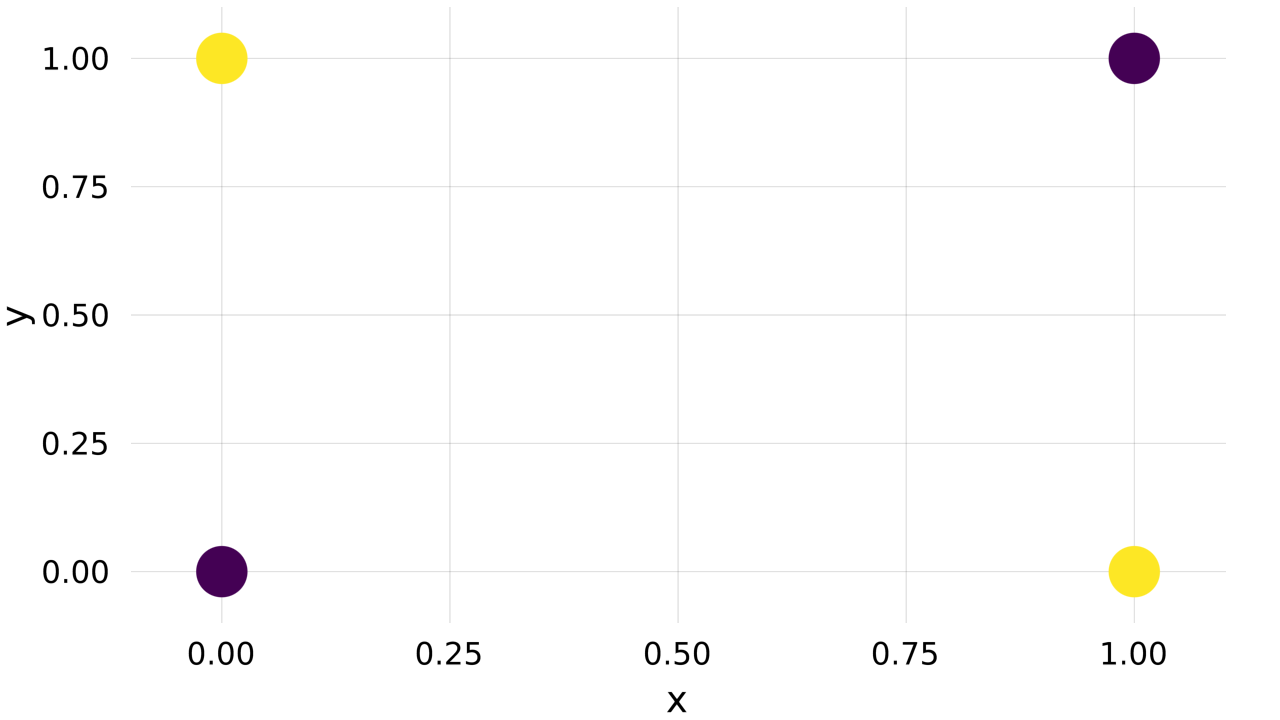

In [17]:
scatter(x, y, color = l)

In [18]:
# DATA

a = rand(Bool, 10000)
b = rand(Bool, 10000)
y = [xor(x1, x2) for (x1, x2) in zip(a, b)]'

X = gpu([a b]')
Y = gpu(vcat(y, .!y))

2×10000 CuArray{Float32,2}:
 1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  1.0  1.0  1.0
 0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0

In [23]:
# NEURAL NETWORK

H      = 4

w1     = gpu(param(randn(H, 2)))
b1     = gpu(param(randn(H)))
fc1(x) = w1 * x .+ b1

w2     = gpu(param(rand(2, H)))
b2     = gpu(param(rand(2)))
fc2(x) = w2 * x .+ b2

neuralnetwork(x)   = softmax(fc2(relu.(fc1(x))))

neuralnetwork (generic function with 1 method)

In [20]:
function update!(ps)
    ƞ = 0.1
    for w in ps
        w.data .-= w.grad .* ƞ
        w.grad .= 0
    end
end

xentropy(ŷ, y) = -sum(log.(ŷ) .* y) / length(y)

loss(x, y)     = xentropy(neuralnetwork(x), y)

accuracy(x, y) = mean(Flux.onecold(m(x)) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [24]:
@showprogress for i in 1:1000
    back!(loss(X, Y))
    update!((w1, b1, w2, b2))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


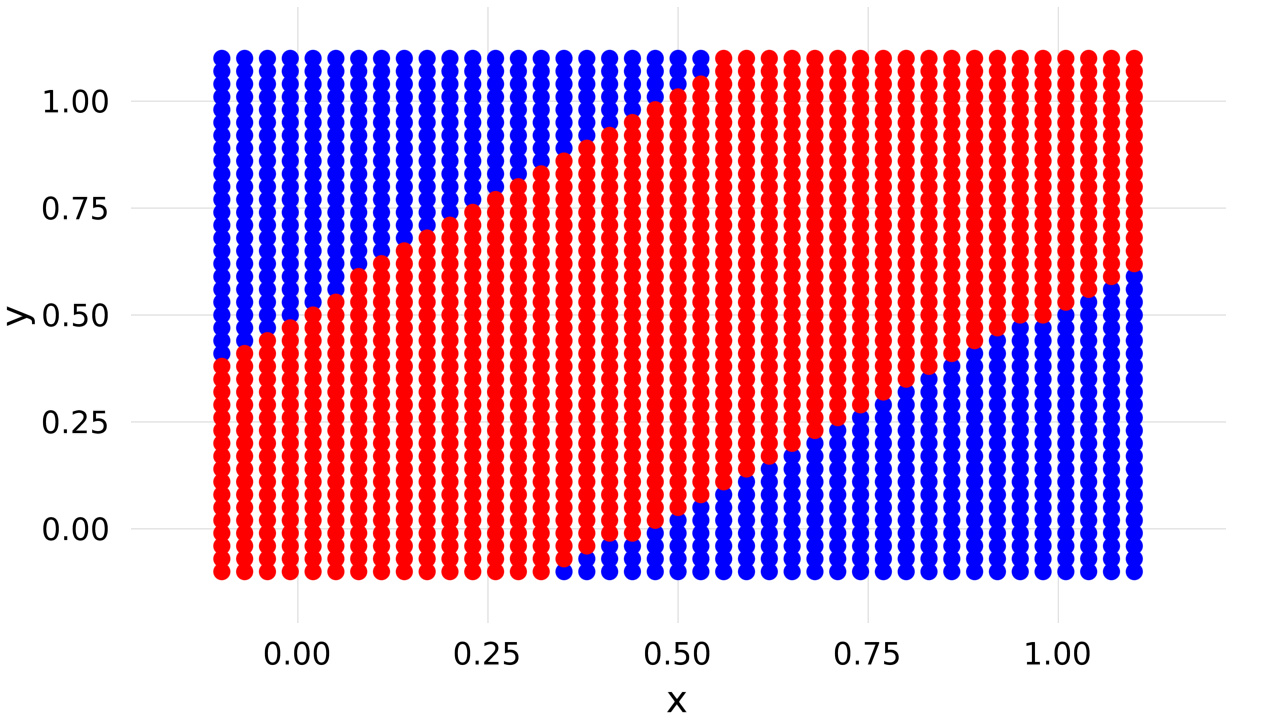

In [25]:
boundary = reshape([gpu([x, y]) for x in collect(-0.1:0.03:1.1), y in collect(-0.1:0.03:1.1)], :)
trues    = Flux.onecold.(neuralnetwork.(boundary)) .== 1
Xt = cpu(hcat(boundary[trues]...))
Yt = cpu(hcat(boundary[.!trues]...))
scatter(Xt[1,:], Xt[2,:], color = :blue, markersize = 0.04)
scatter!(Yt[1,:], Yt[2,:], color = :red, markersize = 0.04)

# Stacking Lines

In [31]:
using Flux: data, train!, @epochs, crossentropy

In [27]:
dnn = gpu(Chain(
    Dense(2, 4, relu),
    Dense(4, 2),
    softmax
))

optimizer = ADAM()

loss(x, y)     = crossentropy(dnn(x), y)

loss (generic function with 1 method)

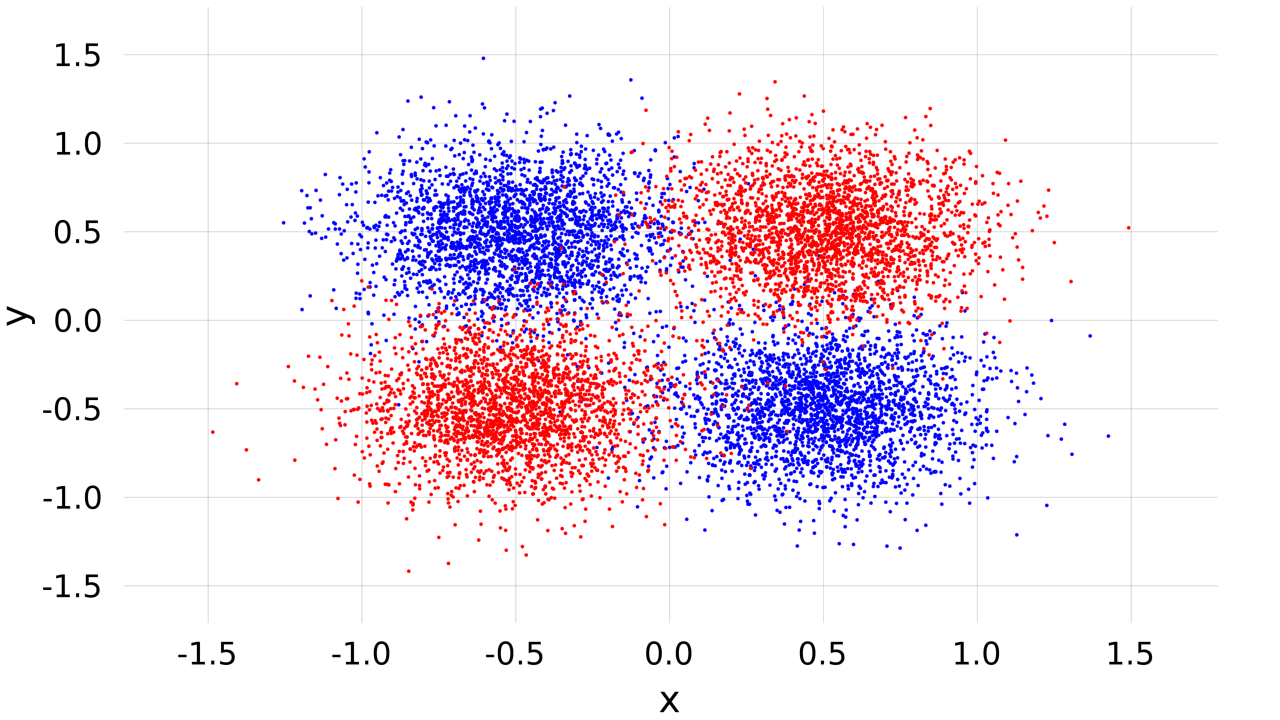

In [28]:
X2   = (cpu(X)*4 .+ randn(2, 10000))/4 .- 0.5
dat  = zip(gpu.([X2[:, i] for i in 1:size(X2, 2)]), gpu.([Y[:, i] for i in 1:size(Y, 2)]))
scatter(X2[1, :][Bool.(cpu(Y[1, :]))], X2[2, :][Bool.(cpu(Y[1, :]))], color = :blue, markersize = 0.02)
scatter!(X2[1,:][Bool.(cpu(Y[2, :]))], X2[2, :][Bool.(cpu(Y[2, :]))], color = :red, markersize = 0.02)

In [32]:
@epochs 5 train!(loss, params(dnn), dat, optimizer)

┌ Info: Epoch 1
└ @ Main C:\Users\rluci\.julia\packages\Flux\zNlBL\src\optimise\train.jl:105
┌ Info: Epoch 2
└ @ Main C:\Users\rluci\.julia\packages\Flux\zNlBL\src\optimise\train.jl:105
┌ Info: Epoch 3
└ @ Main C:\Users\rluci\.julia\packages\Flux\zNlBL\src\optimise\train.jl:105
┌ Info: Epoch 4
└ @ Main C:\Users\rluci\.julia\packages\Flux\zNlBL\src\optimise\train.jl:105
┌ Info: Epoch 5
└ @ Main C:\Users\rluci\.julia\packages\Flux\zNlBL\src\optimise\train.jl:105


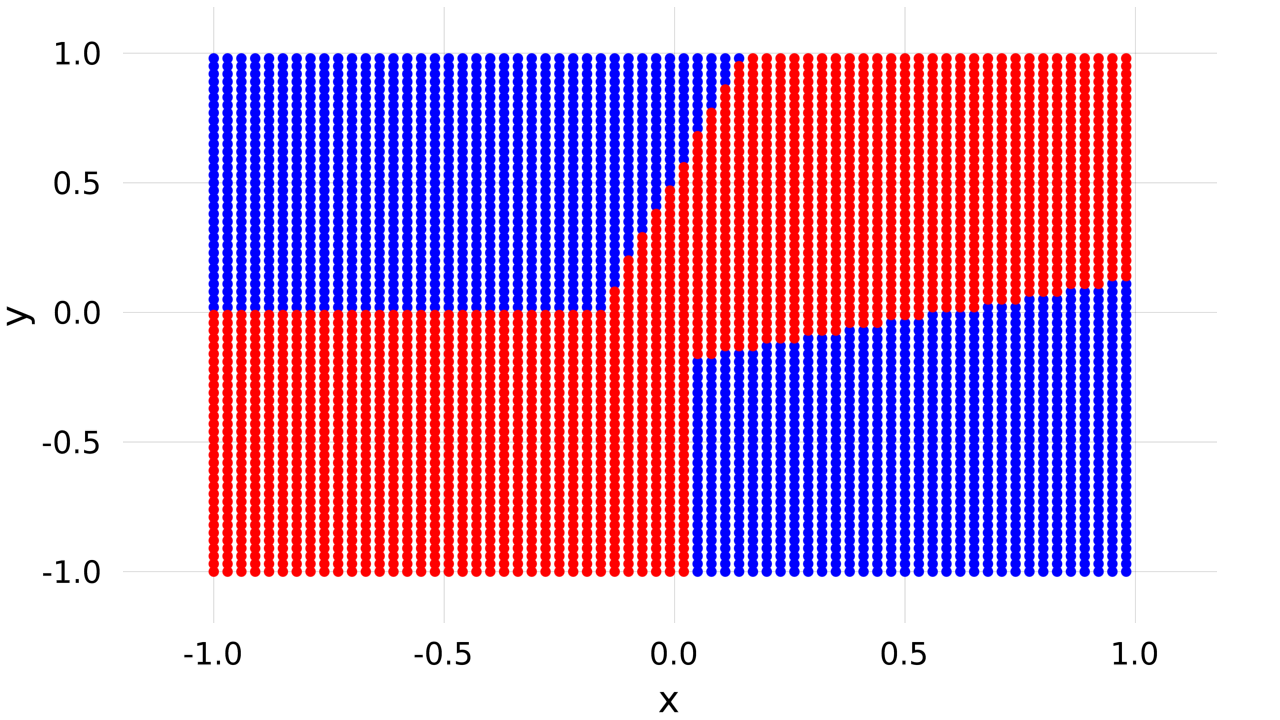

In [33]:
boundary = reshape([gpu([x, y]) for x in collect(-1:0.03:1), y in collect(-1:0.03:1)], :)
trues    = Flux.onecold.(dnn.(boundary)) .== 1
Xt = cpu(hcat(boundary[trues]...))
Yt = cpu(hcat(boundary[.!trues]...))
scatter(Xt[1,:], Xt[2,:], color = :blue, markersize = 0.04)
scatter!(Yt[1,:], Yt[2,:], color = :red, markersize = 0.04)

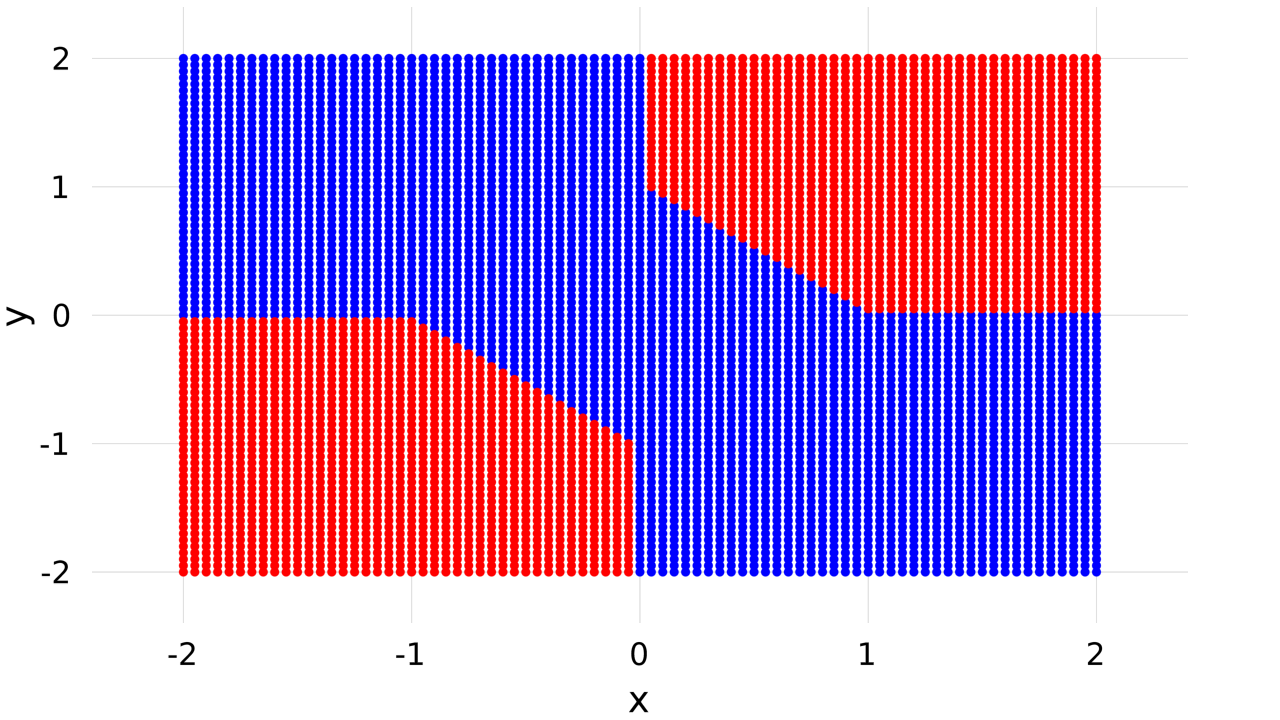

In [35]:
# LAYER 1
dnn.layers[1].W.data .= gpu([1 -1; -1 -1; -1 1; 1 1])
dnn.layers[1].b.data .= gpu([1; 1; 1; 1])

# LAYER 2
dnn.layers[2].W.data .= gpu([1 0 1 0; 0 1 0 1])
dnn.layers[2].b.data .= gpu([0; 0])

boundary = reshape([gpu([x, y]) for x in collect(-2:0.05:2), y in collect(-2:0.05:2)], :)
trues    = Flux.onecold.(dnn.(boundary)) .== 1
Xt = cpu(hcat(boundary[trues]...))
Yt = cpu(hcat(boundary[.!trues]...))
scatter(Xt[1,:], Xt[2,:], color = :blue, markersize = 0.07)
scatter!(Yt[1,:], Yt[2,:], color = :red, markersize = 0.07)

# Cutting up Dimensions

In [48]:
using Flux: mse, throttle, onehotbatch
using Base.Iterators: partition
using MLDatasets
using BSON

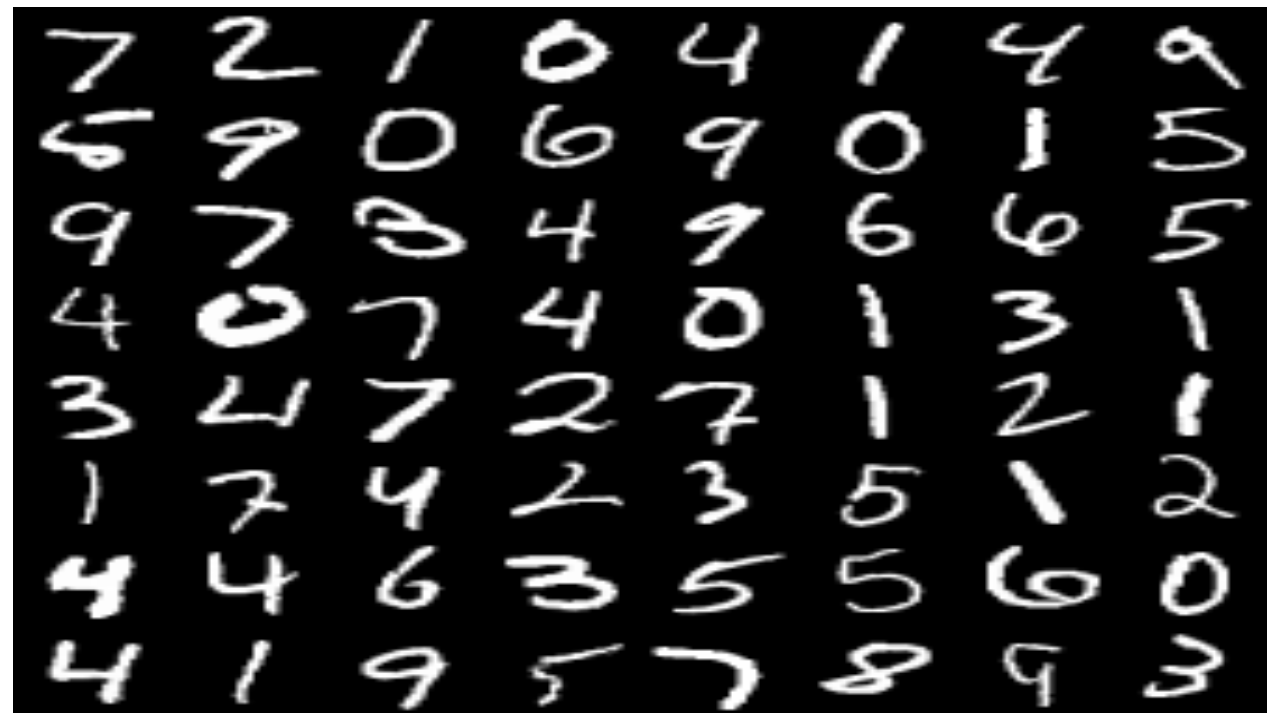

In [37]:
dat_x, dat_y = MLDatasets.MNIST.traindata(Float32)
val_x, val_y = MLDatasets.MNIST.testdata(Float32)

batchsize = 10
dat_x = gpu.([reshape(dat_x[:,:,i:i+batchsize-1], :, batchsize) for i in 1:batchsize:size(dat_x, 3)])
val_x = gpu(hcat([vec(val_x[:,:,i]) for i in 1:size(val_x, 3)]...))

function viewmnist(x, d = 64)
    stride = round(Int, sqrt(d))
    img = [reshape(x[:,i], 28, 28) for i in 1:d]
    img = reshape(img, stride, :)
    out = [cat(img[i,1:end]..., dims = 2) for i in 1:stride]
    out = cpu(cat(out..., dims = 1)[:,end:-1:1])
    image(out, show_axis=false)
end

function cbmnist(x, d = 64)
    stride = round(Int, sqrt(d))
    img = [reshape(x[:,i], 28, 28) for i in 1:d]
    img = reshape(img, stride, :)
    out = [cat(img[i,1:end]..., dims = 2) for i in 1:stride]
    out = cpu(cat(out..., dims = 1)[:,end:-1:1])
    display(image(out, show_axis=false))
    yield()
end

viewmnist(val_x)

In [38]:
act = leakyrelu

encoder = gpu(Chain(
    Dense(28^2, 512, act),
    Dense(512, 128, act),
    Dense(128, 10, act),
    Dense(10, 2)))
    
decoder = gpu(Chain(
    Dense(2, 10, act),
    Dense(10, 128, act),
    Dense(128, 512, act),
    Dense(512, 28^2, act)))
    
model = Chain(encoder, decoder)

evalcb = throttle(() -> cbmnist(data(model(val_x))), 2)
loss(x) = mse(model(x), x)
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

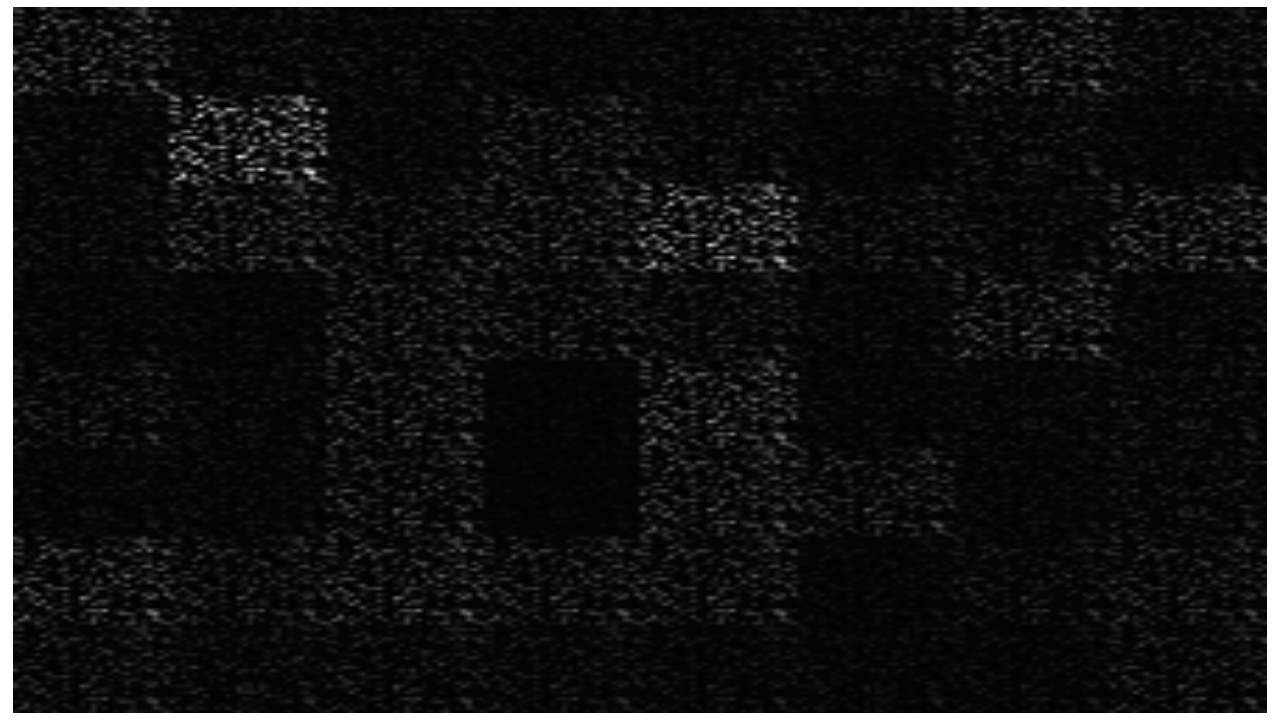

In [39]:
viewmnist(data(model(val_x)))

In [44]:
Flux.train!(loss, params(model), zip(dat_x), opt, cb = evalcb)

┌ Info: Epoch 1
└ @ Main C:\Users\rluci\.julia\packages\Flux\zNlBL\src\optimise\train.jl:105
┌ Info: Epoch 2
└ @ Main C:\Users\rluci\.julia\packages\Flux\zNlBL\src\optimise\train.jl:105
┌ Info: Epoch 3
└ @ Main C:\Users\rluci\.julia\packages\Flux\zNlBL\src\optimise\train.jl:105


In [ ]:
BSON.@load "mnist_autoencoder.bson" enc dec
encoder = gpu(enc)
decoder = gpu(dec)

In [41]:
using MultivariateStats
tX, tY = MNIST.traindata(Float32)
vX, vY = MNIST.testdata(Float32)
M = fit(PCA, reshape(tX, :, 60000); maxoutdim = 2)
components = transform(M, reshape(vX, :, 10000))

2×10000 Array{Float32,2}:
 -1.30307   0.0811202  -3.70995  4.8388    …  -1.05961  -1.23152    4.08775 
  2.93254  -3.74739    -1.68958  0.442904      2.34066  -0.425896  -0.354959

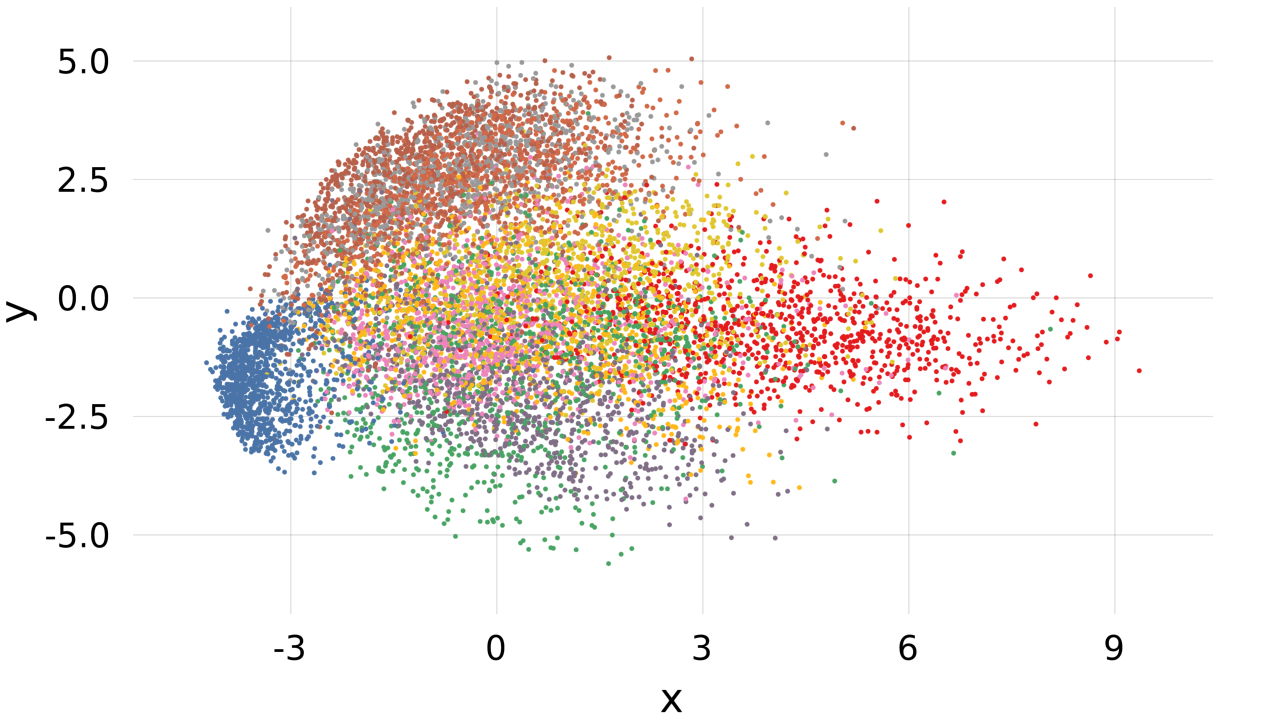

In [42]:
colors = to_colormap(:Set1, 10)
scatter(components[1, :], components[2, :], 
        color=[colors[y+1] for y in vY])

In [51]:
latentspace_dnn = cpu(encoder(val_x).data)

2×10000 Array{Float32,2}:
  4.4307  -0.645843   3.69505   -1.21988  …  1.62619  7.47258  -6.42496
 10.5908   0.295357  -0.277225  -1.5213      2.48446  6.81984   6.66043

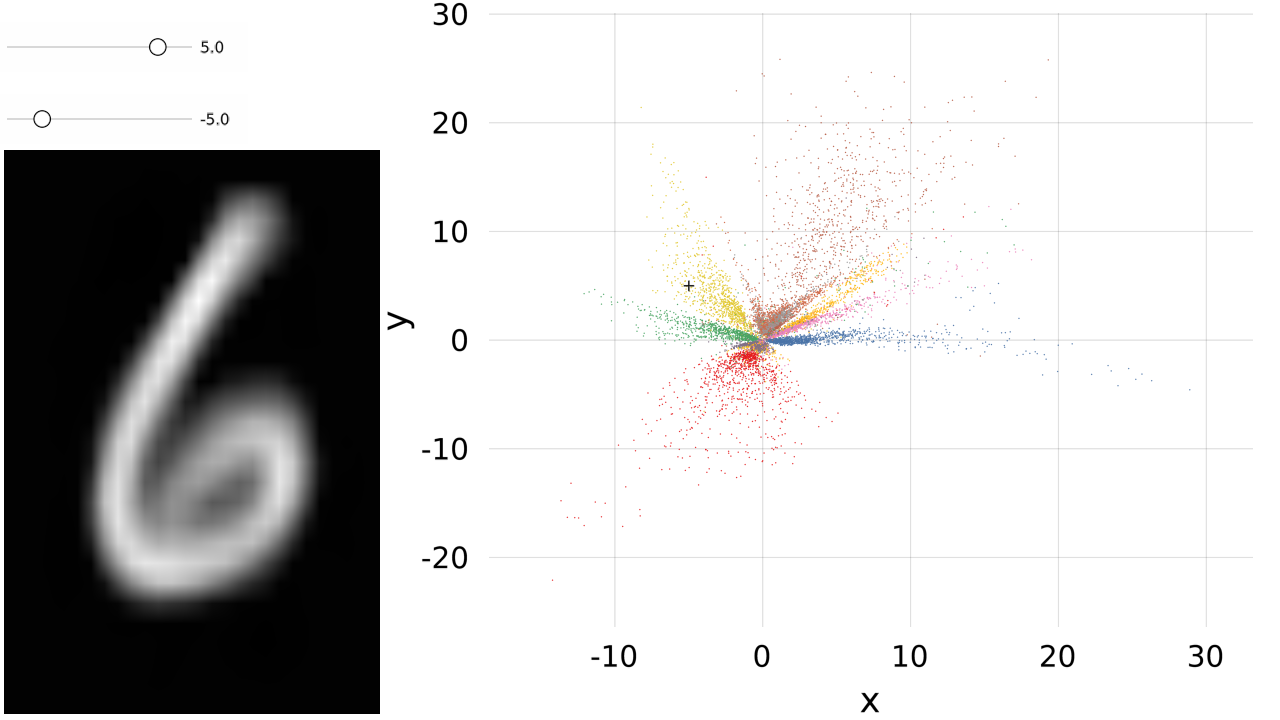

In [76]:
decodeimg(x, y) = cpu(reshape(decoder(gpu([x, y])), 28, 28).data[:, end:-1:1])

s1 = slider(-8.0:0.1:8.0, raw = true, camera = campixel!, start = -5.0)
s2 = slider(-8.0:0.1:8.0, raw = true, camera = campixel!, start = 5.0)
xy = lift((x, y)->[to_value(x) to_value(y)], s1[end][:value], s2[end][:value])

digit   = lift((x, y) -> decodeimg(to_value(x), to_value(y)), s1[end][:value], s2[end][:value])
scene_d = image(digit, show_axis = false)

scene_s = scatter(latentspace_dnn[1,:], latentspace_dnn[2,:], color=[colors[y+1] for y in vY])
scene_s = scatter!(scene_s, xy, color=:black, marker='+', markersize=1)

vbox(hbox(scene_d, s1, s2, sizes=[0.8, 0.1, 0.1]), scene_s, sizes=[0.3, 0.7])

# Descending into the (loss) abyss

In [53]:
using Flux.Optimise
using Flux.Optimise: apply!
using ImageFiltering

In [54]:
function zdepth(xy, xmap, ymap, zmap)
    x, y = xy.data
    try
        zx = findfirst(v->v>x, xmap)-1
        zy = findfirst(v->v>y, ymap)-1      
        return [x, y, zmap[zx, zy]]
    catch
        return [x, y, zero(typeof(x))]
    end
end

function zgrad!(xy, xmap, ymap, zmap)
    x, y = xy.data
    try
        zx = findfirst(v->v>x, xmap)-1
        zy = findfirst(v->v>y, ymap)-1
        xgrad = zmap[zx, zy] - zmap[zx+1, zy]
        ygrad = zmap[zx, zy] - zmap[zx, zy+1]
        copyto!(xy.grad, [xgrad, ygrad])
    catch
        return
    end
end

function descend(xy, xres, yres, zmap, opt, steps, zbuf)
    out = []
    for i in 1:steps
        zgrad!(xy, xres, yres, zmap)
        Δ = apply!(opt, xy.data, xy.grad)
        xy.data .+= Δ
        x, y, z = zdepth(xy, xres, yres, zmap)
        push!(out, [x, y, Float32(z + zbuf)])
    end
    return Point3f0.(out)
end

descend (generic function with 1 method)

In [55]:
# MONKEY SADDLE
testxres = -1:0.01:1
testyres = -1:0.01:1
monkey(x, y) = (x^3 - 3x*y^2)
testzmap = -[monkey(x, y) for x in testxres, y in testyres]
max, min = extrema(testzmap)
testzmap = (testzmap .- min) ./ (max - min)

zgrad! (generic function with 1 method)

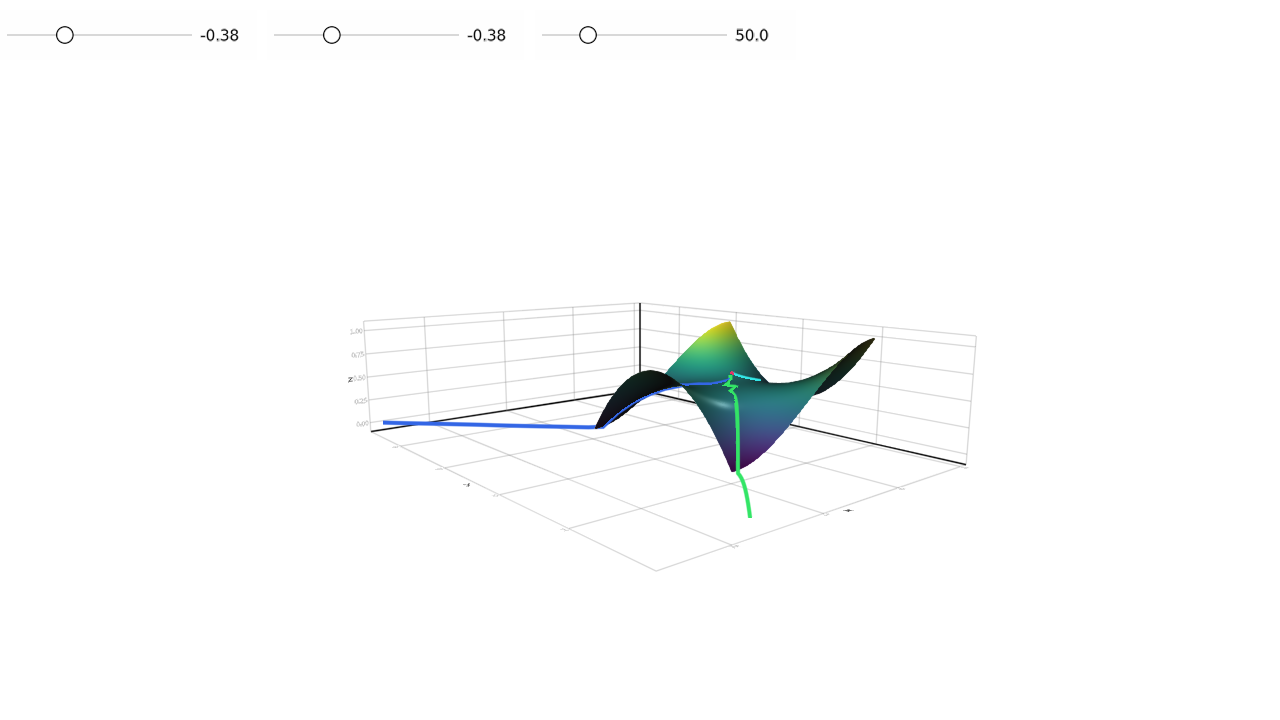

In [82]:
s1 = slider(testxres, raw = true, camera = campixel!, start = -0.38)
s2 = slider(testyres, raw = true, camera = campixel!, start = -0.38)
s3 = slider(1:1:200, raw = true, camera = campixel!, start = 50)

pathSGD = lift((x, y, i) -> 
            descend(param([to_value(x) to_value(y)]), testxres, testyres, testzmap,
            Descent(0.5), to_value(i), 0.004), s1[end][:value], s2[end][:value], s3[end][:value])

pathNesterov = lift((x, y, i) -> 
            descend(param([to_value(x) to_value(y)]), testxres, testyres, testzmap, 
            Nesterov(0.5), to_value(i), 0.003), s1[end][:value], s2[end][:value], s3[end][:value])

pathADAM = lift((x, y, i) -> 
            descend(param([to_value(x) to_value(y)]), testxres, testyres, testzmap, 
            ADAM(0.05), to_value(i), 0.003), s1[end][:value], s2[end][:value], s3[end][:value])


pathRMSProp = lift((x, y, i) -> 
            descend(param([to_value(x) to_value(y)]), testxres, testyres, testzmap, 
            RMSProp(0.05), to_value(i), 0.003), s1[end][:value], s2[end][:value], s3[end][:value])


scene_s = surface(testxres, testyres, testzmap)
lines!(scene_s, pathADAM, color = RGBAf0(0.2, 0.9, 0.4, 1), linewidth = 4)
lines!(scene_s, pathNesterov, color = RGBAf0(0.2, 0.9, 0.9, 1), linewidth = 4)
lines!(scene_s, pathRMSProp, color = RGBAf0(0.2, 0.4, 0.9, 1), linewidth = 4)
lines!(scene_s, pathSGD, color = RGBAf0(0.9, 0.2, 0.4, 1), linewidth = 4)

hbox(scene_s, vbox(s1, s2, s3))

# Visualizing the Loss Landscape

In [57]:
using Statistics
using Statistics: norm
using Flux: onecold

In [58]:
vgg = gpu(Chain(
    Conv((3, 3), 1 => 64, relu, pad=(1, 1)),
    BatchNorm(64),
    Conv((3, 3), 64 => 64, relu, pad=(1, 1)),
    BatchNorm(64),
    x -> maxpool(x, (2, 2)),

    Conv((3, 3), 64 => 128, relu, pad=(1, 1)),
    BatchNorm(128),
    Conv((3, 3), 128 => 128, relu, pad=(1, 1)),
    BatchNorm(128),
    x -> maxpool(x, (2, 2)),

    Conv((3, 3), 128 => 256, relu, pad=(1, 1)),
    BatchNorm(256),
    Conv((3, 3), 256 => 256, relu, pad=(1, 1)),
    BatchNorm(256),
    Conv((3, 3), 256 => 256, relu, pad=(1, 1)),
    BatchNorm(256),
    x -> maxpool(x, (2, 2)),

    Conv((3, 3), 256 => 512, relu, pad=(1, 1)),
    BatchNorm(512),
    Conv((3, 3), 512 => 512, relu, pad=(1, 1)),
    BatchNorm(512),
    Conv((3, 3), 512 => 512, relu, pad=(1, 1)),
    BatchNorm(512),
    x -> maxpool(x, (2, 2)),

    x -> reshape(x, :, size(x, 4)),
    Dense(512, 4096, relu),
    Dense(4096, 4096, relu),
    Dropout(0.5),
    Dense(4096, 10),
    softmax))

loss(x, y) = Flux.crossentropy(vgg(x), y)

accuracy(m, x, y) = mean(cpu(onecold(m(x[1]), 0:9)) .== onecold(y[1], 0:9))

evalcb = throttle(() -> @show(accuracy(vgg, dat_x, dat_y)), 10)

opt = ADAM()

Chain(Conv((3, 3), 1=>64, NNlib.relu), BatchNorm(64), Conv((3, 3), 64=>64, NNlib.relu), BatchNorm(64), getfield(Main, Symbol("##81#86"))(), Conv((3, 3), 64=>128, NNlib.relu), BatchNorm(128), Conv((3, 3), 128=>128, NNlib.relu), BatchNorm(128), getfield(Main, Symbol("##82#87"))(), Conv((3, 3), 128=>256, NNlib.relu), BatchNorm(256), Conv((3, 3), 256=>256, NNlib.relu), BatchNorm(256), Conv((3, 3), 256=>256, NNlib.relu), BatchNorm(256), getfield(Main, Symbol("##83#88"))(), Conv((3, 3), 256=>512, NNlib.relu), BatchNorm(512), Conv((3, 3), 512=>512, NNlib.relu), BatchNorm(512), Conv((3, 3), 512=>512, NNlib.relu), BatchNorm(512), getfield(Main, Symbol("##84#89"))(), getfield(Main, Symbol("##85#90"))(), Dense(512, 4096, NNlib.relu), Dense(4096, 4096, NNlib.relu), Dropout{Float64}(0.5, true), Dense(4096, 10), NNlib.softmax)

In [ ]:
dat_x, dat_y = FashionMNIST.traindata(Float32)
val_x, val_y = FashionMNIST.testdata(Float32)

batchsize = 10
dat_x = gpu.([reshape(dat_x[:,:,i:i+batchsize-1], 28, 28, 1, :) for i in 1:batchsize:size(dat_x, 3)])[1:500]
dat_y = gpu.([onehotbatch(dat_y[i:i+batchsize-1], 0:9) for i in 1:batchsize:length(dat_y)])[1:500]

val_x = gpu(reshape(val_x, 28, 28, 1, :))
val_y = gpu(onehotbatch(val_y, 0:9))

dat = zip(dat_x, dat_y);

In [ ]:
# Flux.train!(loss, params(vgg), dat, opt, cb = evalcb)

BSON.@load "vgg.bson" model
vgg = gpu(model)

In [62]:
getweights(layer::T) where T <: Conv = copy(layer.weight.data)
getweights(layer::T) where T <: Dense = copy(layer.W.data)

function writeweights!(layer, weights)
    typeof(layer) <: Conv ? copyto!(layer.weight.data, weights) : copyto!(layer.W.data, weights)
end

function updateweights!(model, weights)
    for (l, w) in weights
        writeweights!(model[l], weights[l])
    end
end

function minimizedweights(layers)
    out = Dict()
    for i in 1:length(layers)
        t = typeof(layers[i])
        if t <: Conv || t <: Dense
            out[i] = getweights(layers[i])
        end
    end
    return out
end

function randomweights(layers)
    out = Dict()
    for i in 1:length(layers)
        t = typeof(layers[i])
        if t <: Conv || t <: Dense
            out[i] = gpu(randn(Float32, size(getweights(layers[i]))))
        end
    end
    return out
end

randomweights (generic function with 1 method)

In [63]:
function gensurface(model, xr, yr, data, labels)
    θm = minimizedweights(model) 
    θ1 = randomweights(model)
    θ2 = randomweights(model) 
    α, β = collect(xr), collect(yr)
    surface = zeros(Float32, length(α), length(β))
    perturbations = Dict()
    @showprogress for i in 1:length(α), j in 1:length(β)
        for (l, w) in θm
            ϕ = α[i] * norm(θm[l]) / norm(θ2[l]) .* θ2[l] .+ (1-α[i]) .* θm[l]
            θ = β[j] * norm(θm[l]) / norm(θ1[l]) .* θ1[l] .+ (1-β[j]) * norm(θm[l]) / norm(ϕ) .* ϕ
            perturbations[l] = θ
        end
        updateweights!(model, perturbations)
        surface[i, j] = crossentropy(model(data[:,:,1:1,1:32]).data, labels[:,1:32])
    end
    updateweights!(model, θm)
    return surface
end

gensurface (generic function with 1 method)

In [64]:
xres = -5f0:0.5f0:5f0
yres = -5f0:0.5f0:5f0
zmap = gensurface(vgg, xres, yres, val_x, val_y)
zmap[isinf.(zmap)] .= 0.0
zmap[zmap .== 0.0] .= maximum(zmap)
zmap = log10.(zmap)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


21×21 Array{Float32,2}:
 1.59923  1.59923  1.59923  1.59923  …  1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923  …  1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923  …  1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 1.59923  1.59923  1.59923  1.59923     1.59923  1.59923  1.59923  1.59923
 

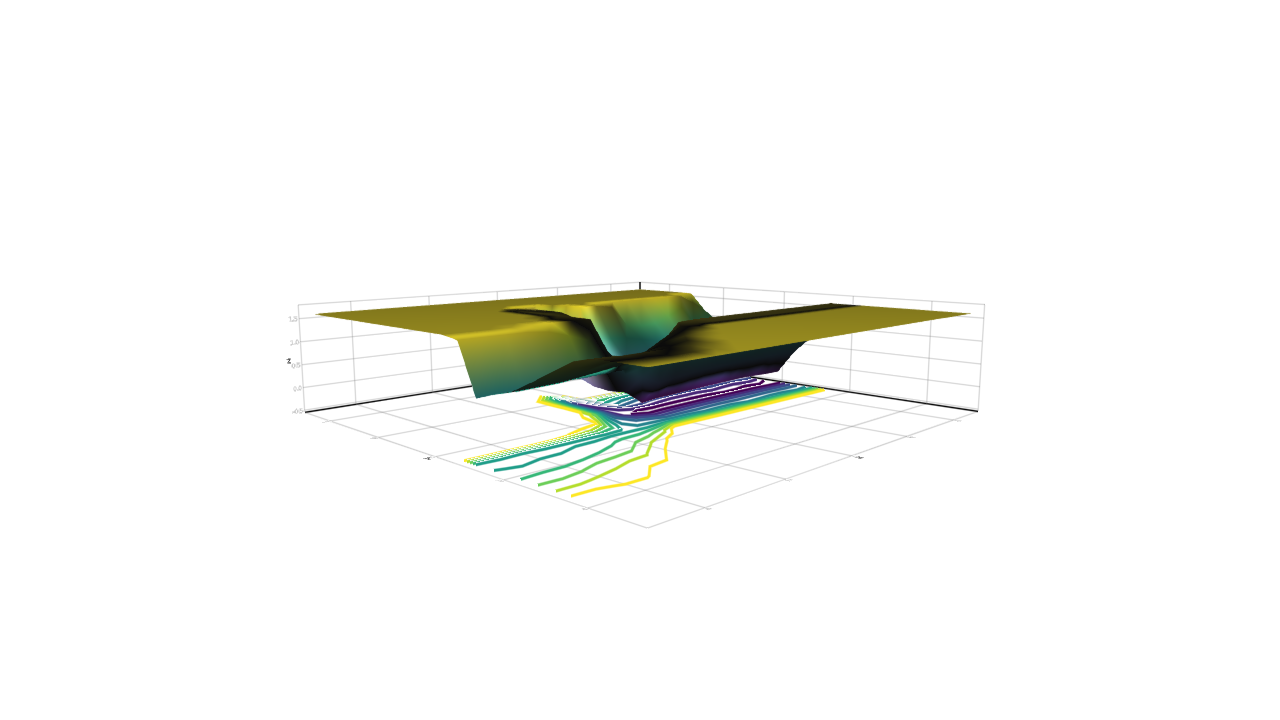

In [65]:
scene_s = surface(xres, yres, zmap)

xm, ym, zm = minimum(scene_s.limits[])
scene_s = contour!(scene_s, xres, yres, zmap, linewidth = 3, levels = 10, transformation = (:xy, zm))

In [92]:
BSON.@load "zmap3.bson" xres yres zmap
testzmap = zmap[end:-1:1, end:-1:1]
testzmap = imfilter(testzmap, Kernel.gaussian(0.7));

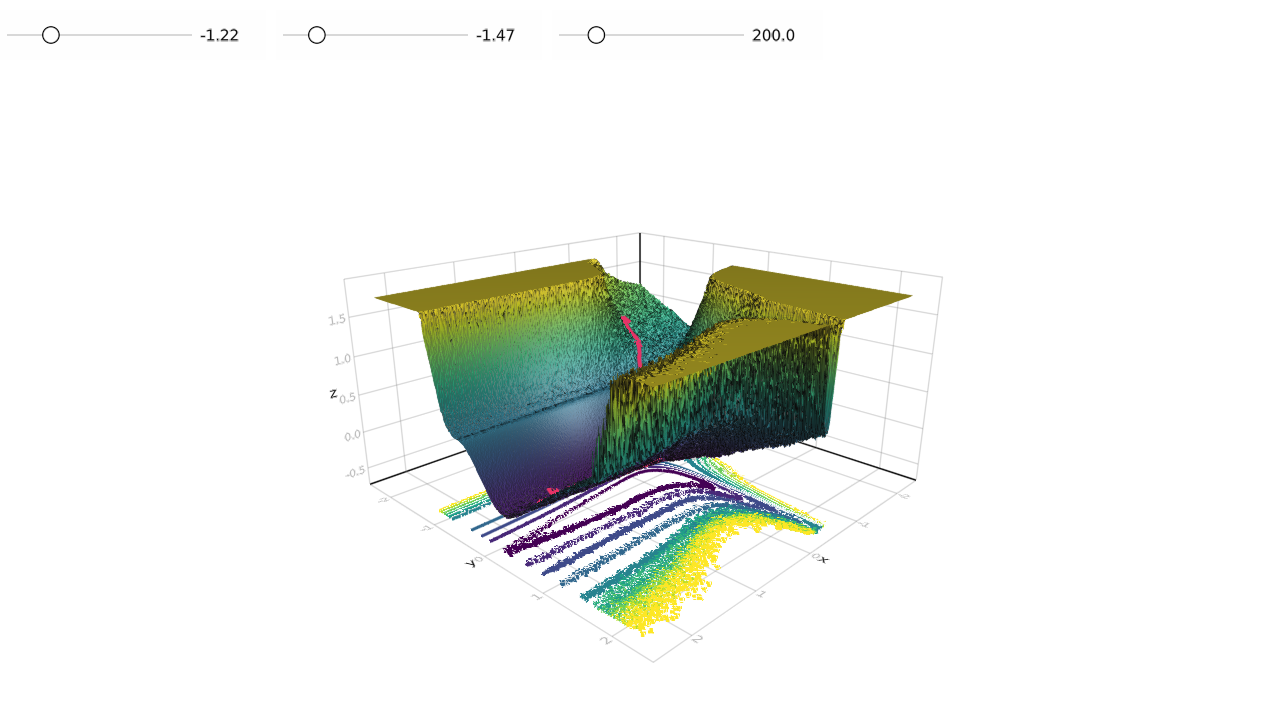

In [95]:
#opt = Descent(2.05)
#opt = Nesterov(2.05)
opt = ADAM(0.1)
#opt = RMSProp(0.05)

s1 = slider(xres, raw = true, camera = campixel!, start = -1.22f0)
s2 = slider(yres, raw = true, camera = campixel!, start = -1.47f0)
s3 = slider(1:1:1000, raw = true, camera = campixel!, start = 200)

path = lift((x, y, i) -> 
            descend(param([to_value(x) to_value(y)]), xres, yres, testzmap, opt, to_value(i), 0.03), 
            s1[end][:value], s2[end][:value], s3[end][:value])

scene_s = surface(xres, yres, testzmap)
lines!(scene_s, path, color = RGBAf0(0.9, 0.2, 0.4, 1), linewidth = 4)
xm, ym, zm = minimum(scene_s.limits[])
scene_s = contour!(scene_s, xres, yres, testzmap, linewidth = 3, levels = 10, transformation = (:xy, zm))

hbox(scene_s, vbox(s1, s2, s3))